# Reproduce CheXNet: Explore Predictions

## Import other modules and pandas

In [1]:
import visualize_prediction as V
import torch
import pandas as pd

#suppress pytorch warnings about source code changes
import warnings
warnings.filterwarnings('ignore')

## Settings for review
We can examine individual results in more detail, seeing probabilities of disease for test images. 

We get you started with a small number of the images from the large NIH dataset. 

To explore the full dataset, [download images from NIH (large, ~40gb compressed)](https://nihcc.app.box.com/v/ChestXray-NIHCC), extract all tar.gz files to a single folder, place that path  below and set STARTER_IMAGES=False

In [2]:
STARTER_IMAGES=True
PATH_TO_IMAGES = "starter_images/"

#STARTER_IMAGES=False
#PATH_TO_IMAGES = "your path to NIH data here"

Load pretrained model (part of cloned repo; should not need to change path unless you want to point to one you retrained)

In [3]:
PATH_TO_MODEL = "pretrained/checkpoint"

Pick the finding you want to see positive examples of:

LABEL can be set to any of:
- Atelectasis
- Cardiomegaly
- Consolidation
- Edema
- Effusion
- Emphysema
- Fibrosis
- Hernia
- Infiltration
- Mass
- Nodule
- Pleural_Thickening
- Pneumonia
- Pneumothorax


In [4]:
LABEL="Infiltration"

It's more interesting when initially exploring to see cases positive for pathology of interest:

In [5]:
POSITIVE_FINDINGS_ONLY=True

## Load data

This loads up dataloader and model (note: only test images not used for model training are loaded).

In [6]:
dataloader,model= V.load_data(PATH_TO_IMAGES,LABEL,PATH_TO_MODEL,POSITIVE_FINDINGS_ONLY,STARTER_IMAGES)
print("Cases for review:")
print(len(dataloader))

Cases for review:
1


## Examine individual cases

To explore, run code below to see a random case positive for your selected finding, a heatmap indicating the most influential regions of the image, and the model's estimated probabilities for findings. For many diagnoses, you can see that the model uses features outside the expected region to calibrate its predictions -- [you can read my discussion about this here](https://medium.com/@jrzech/what-are-radiological-deep-learning-models-actually-learning-f97a546c5b98).

Please note that:
1) the NIH dataset was noisily labeled by automatically extracting labels from text reports written by radiologists, as described in paper [here](https://arxiv.org/pdf/1705.02315.pdf) and analyzed [here](https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/), so we should not be surprised to see inaccuracies in the provided ground truth labels 
2) high AUCs can be achieved even if many positive cases are assigned absolutely low probabilities of disease, as AUC depends on the relative ranking of probabilities between cases. 

You can run the below cell repeatedly to see different examples:

In [7]:
def recursion_change_bn(module):
    if isinstance(module, torch.nn.BatchNorm2d):
        module.track_running_stats = 1
    if isinstance(module, torch.nn.Conv2d):
        module.padding_mode = 1
    else:
        for i, (name, module1) in enumerate(module._modules.items()):
            module1 = recursion_change_bn(module1)
    return module 

In [8]:
for i, (name, module) in enumerate(model._modules.items()):
    module = recursion_change_bn(model)
    model.eval()

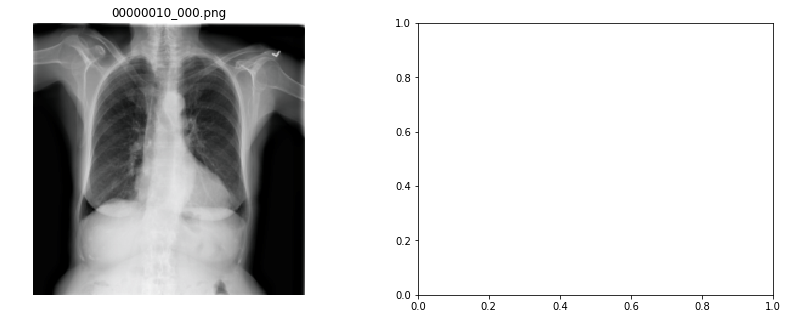

Predicted Probability  Ground Truth
Finding                                               
Atelectasis                        0.038         False
Cardiomegaly                       0.068         False
Effusion                           0.013         False
Infiltration                       0.132          True
Mass                               0.004         False
Nodule                             0.027         False
Pneumonia                          0.005         False
Pneumothorax                       0.043         False
Consolidation                      0.005         False
Edema                              0.000         False
Emphysema                          0.021         False
Fibrosis                           0.101         False
Pleural_Thickening                 0.025         False
Hernia                             0.011         False

In [9]:
preds=V.show_next(dataloader,model, LABEL)
preds

In [10]:
checkpoint = torch.load(PATH_TO_MODEL, map_location=lambda storage, loc: storage)
model = checkpoint['model']
del checkpoint

In [1]:
import cxr_dataset as CXR
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [2]:
# build dataloader on test
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [12]:
data_transform = transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

if not POSITIVE_FINDINGS_ONLY:
    finding = "any"
else:
    finding = LABEL

dataset = CXR.CXRDataset(
    path_to_images=PATH_TO_IMAGES,
    fold='test',
    transform=data_transform,
    finding=finding,
    starter_images=STARTER_IMAGES)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=1)

In [13]:
inputs, labels, filename = next(iter(dataloader))

In [14]:
dummy_input = torch.autograd.Variable(inputs.cpu())

In [16]:
import onnx
from onnx_tf.backend import prepare

ModuleNotFoundError: No module named 'onnx'

In [17]:
torch.__version__

'1.0.1'

In [18]:
for i, (name, module) in enumerate(model._modules.items()):
    module = recursion_change_bn(model)
    model.eval()

In [19]:
torch.onnx.export(model, dummy_input, 'pretrained/checkpoint2.onnx', input_names=['input'], output_names=['output'])

In [20]:
model_onnx = onnx.load('pretrained/checkpoint2.onnx')

tf_rep = prepare(model_onnx, strict=False)

# Print out tensors and placeholders in model (helpful during inference in TensorFlow)
print(tf_rep.tensor_dict)

# Export model as .pb file
tf_rep.export_graph('pretrained/checkpoint2.tf')

W0730 13:24:11.864960 139833028875648 deprecation.py:323] From /home/dennys_mallqui/anaconda3/envs/pytorch/lib/python3.6/site-packages/onnx_tf/handlers/backend/reshape.py:26: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0730 13:24:11.870947 139833028875648 deprecation.py:323] From /home/dennys_mallqui/anaconda3/envs/pytorch/lib/python3.6/site-packages/onnx_tf/handlers/backend/reshape.py:31: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0730 13:24:11.915610 139833028875648 deprecation.py:323] From /home/dennys_mallqui/anaconda3/envs/pytorch/lib/python3.6/site-packages/onnx_tf/handlers/backend/gemm.py:14: flatten (from tensorflow.python.layers.cor

{'1': <tf.Tensor 'Const:0' shape=(64, 3, 7, 7) dtype=float32>, '2': <tf.Tensor 'Const_1:0' shape=(64,) dtype=float32>, '3': <tf.Tensor 'Const_2:0' shape=(64,) dtype=float32>, '4': <tf.Tensor 'Const_3:0' shape=(64,) dtype=float32>, '5': <tf.Tensor 'Const_4:0' shape=(64,) dtype=float32>, '6': <tf.Tensor 'Const_5:0' shape=(64,) dtype=float32>, '7': <tf.Tensor 'Const_6:0' shape=(64,) dtype=float32>, '8': <tf.Tensor 'Const_7:0' shape=(64,) dtype=float32>, '9': <tf.Tensor 'Const_8:0' shape=(64,) dtype=float32>, '10': <tf.Tensor 'Const_9:0' shape=(128, 64, 1, 1) dtype=float32>, '11': <tf.Tensor 'Const_10:0' shape=(128,) dtype=float32>, '12': <tf.Tensor 'Const_11:0' shape=(128,) dtype=float32>, '13': <tf.Tensor 'Const_12:0' shape=(128,) dtype=float32>, '14': <tf.Tensor 'Const_13:0' shape=(128,) dtype=float32>, '15': <tf.Tensor 'Const_14:0' shape=(32, 128, 3, 3) dtype=float32>, '16': <tf.Tensor 'Const_15:0' shape=(96,) dtype=float32>, '17': <tf.Tensor 'Const_16:0' shape=(96,) dtype=float32>, '1

In [15]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
from configparser import ConfigParser
from models.keras import ModelFactory
import tensorflow as tf

def load_pb(path_to_pb):
    with tf.gfile.GFile(path_to_pb, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        return graph

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img,data_format='channels_first')# (channels, height, width)
    # img_tensor = image.img_to_array(img)# (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    return img_tensor

Using TensorFlow backend.


In [16]:
pb_model_path='./pretrained/checkpoint2.tf'
graph = tf.Graph()
with graph.as_default():
    print("** load model **")
    graph = load_pb(pb_model_path)
    # print(graph.get_operations())

** load model **


In [17]:
tf.__version__

'1.14.0'

In [18]:
print(graph.get_operations())

[<tf.Operation 'Const' type=Const>, <tf.Operation 'Const_1' type=Const>, <tf.Operation 'Const_2' type=Const>, <tf.Operation 'Const_3' type=Const>, <tf.Operation 'Const_4' type=Const>, <tf.Operation 'Const_5' type=Const>, <tf.Operation 'Const_6' type=Const>, <tf.Operation 'Const_7' type=Const>, <tf.Operation 'Const_8' type=Const>, <tf.Operation 'Const_9' type=Const>, <tf.Operation 'Const_10' type=Const>, <tf.Operation 'Const_11' type=Const>, <tf.Operation 'Const_12' type=Const>, <tf.Operation 'Const_13' type=Const>, <tf.Operation 'Const_14' type=Const>, <tf.Operation 'Const_15' type=Const>, <tf.Operation 'Const_16' type=Const>, <tf.Operation 'Const_17' type=Const>, <tf.Operation 'Const_18' type=Const>, <tf.Operation 'Const_19' type=Const>, <tf.Operation 'Const_20' type=Const>, <tf.Operation 'Const_21' type=Const>, <tf.Operation 'Const_22' type=Const>, <tf.Operation 'Const_23' type=Const>, <tf.Operation 'Const_24' type=Const>, <tf.Operation 'Const_25' type=Const>, <tf.Operation 'Const_26

In [19]:
img_path_001 = './data/00000344_000.PNG'
new_image_001 = load_image(img_path_001)

In [20]:
tf_graph = load_pb('./pretrained/checkpoint2.tf')
sess = tf.Session(graph=tf_graph)

output_tensor = tf_graph.get_tensor_by_name('Sigmoid:0')
input_tensor = tf_graph.get_tensor_by_name('input:0')

output = sess.run(output_tensor, feed_dict={input_tensor: dummy_input})
print(output)

InvalidArgumentError: Default MaxPoolingOp only supports NHWC on device type CPU
	 [[node max_pool (defined at <ipython-input-15-c0292792d322>:15) ]]

Original stack trace for 'max_pool':
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-1934d257eb5a>", line 1, in <module>
    tf_graph = load_pb('./pretrained/checkpoint2.tf')
  File "<ipython-input-15-c0292792d322>", line 15, in load_pb
    tf.import_graph_def(graph_def, name='')
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tensorflow\python\framework\importer.py", line 443, in import_graph_def
    _ProcessNewOps(graph)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tensorflow\python\framework\importer.py", line 236, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tensorflow\python\framework\ops.py", line 3751, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tensorflow\python\framework\ops.py", line 3751, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tensorflow\python\framework\ops.py", line 3641, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "C:\Users\dm plaza\.conda\envs\cnnGestureRecognizer\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()
